In [2]:
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

sys.path.append('/home/mjovanovic/Work/LCStudies')
from  util import graph_util as gu

In [1]:
# write an empty dataset for pnet train 1
N = 100
file = "train"

for i in range(20):
    X = np.random.rand(6000, N, 4)
    Y = np.random.rand(6000, N, 1)

    if i >= 15:
        file = "val"

    np.savez('./train_1/' + file + '/data_' + str(i) + '.npz', X=X, Y=Y)



In [2]:
# load cell geo tree dict (takes ~6 min)
file = uproot.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]
cell_dict = gu.loadGraphDictionary(cell_geo_tree)

In [30]:
import time
time_start = time.time()
pion_dir = "/data/mjovanovic/train_testing_data/pion_files"
pi0_num = 14
pipm1_num = 13
pipm2_num = 14
max_cells = 0

file = pion_dir + "/pi0_" + str(pi0_num) + "_pipm_" + str(pipm1_num) + "_" + str(pipm2_num) + "_len_6000_i_0.npy"

events_arr = ak.Array(np.load(file, allow_pickle=True).item())
print("loaded file as ak array:", str(time.time() - time_start)) # ~25 s

cell_ids = ak.flatten(events_arr["cluster_cell_ID"])
phis = []
etas = []
rs = []
for clus_ids in cell_ids:
    phis.append(gu.convertIDToGeo(clus_ids, "cell_geo_phi", cell_dict))
    etas.append(gu.convertIDToGeo(clus_ids, "cell_geo_eta", cell_dict))
    rs.append(gu.convertIDToGeo(clus_ids, "cell_geo_rPerp", cell_dict))
    if len(clus_ids) > max_cells:
        max_cells = len(clus_ids)
print("looked up coords:", str(time.time() - time_start))

cluster_cell_E = ak.flatten(events_arr["cluster_cell_E"])
cell_EM_frac = ak.flatten(events_arr["cluster_cell_hitsE_EM"])/(ak.flatten(events_arr["cluster_cell_hitsE_EM"]) + ak.flatten(events_arr["cluster_cell_hitsE_nonEM"]))
print("num grouped ids:", len(cell_ids))
print("num grouped coords:", len(phis))
print("num grouped truth E:", len(cluster_cell_E))
print("num grouped EM frac:", len(cell_EM_frac)) # check for nan when tot energy ~= 0 => mask those cells?
print("get cell data:", str(time.time() - time_start))

point_data = np.zeros((len(cell_ids), max_cells, 4))
for i, clus_phi in enumerate(phis):
    point_data[i, :len(clus_phi)] = np.transpose([phis[i], etas[i], rs[i], cluster_cell_E[i]])


print("total num clus:", np.sum(events_arr["nCluster"]))

loaded file as ak array: 21.194230794906616
looked up coords: 30.93170428276062
num grouped ids: 9740
num grouped coords: 9740
num grouped truth E: 9740
num grouped EM frac: 9740
get cell data: 30.942880153656006
total num clus: 9740


In [22]:

print(len(point_data))

9740


In [36]:
import yaml

# load config info
config_file = "./preprocess_events_to_pnet_npz_config.yaml"
config = yaml.load(open(config_file), Loader=yaml.FullLoader)

pion_dir = config["pion_dir"]
save_dir = config["save_dir"]
pi0_file_nums = config["pi0_file_nums"]
pipm1_file_nums = config["pipm1_file_nums"]
pipm2_file_nums = config["pipm2_file_nums"]
len_file = config["len_file"]
i_low = config["i_low"]
i_high = config["i_high"]
num_procs = config["num_procs"]

# load cell geo tree dict
#file = uproot.open("/data/atlas/data/rho_delta/rho_small.root")
#cell_geo_tree = file["CellGeo"]
#cell_dict = gu.loadGraphDictionary(cell_geo_tree)

pion_files = []
for j, pi0_num in enumerate(pi0_file_nums):
    pion_files.extend(list(map(lambda i: "/pi0_" + str(pi0_num) + "_pipm_" + str(pipm1_file_nums[j]) + "_" + str(pipm2_file_nums[j]) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy", np.arange(i_low, i_high + 1))))

for file in pion_files:
    events_arr = ak.Array(np.load(pion_dir + file, allow_pickle=True).item())
    print("loaded events as ak array")

    cell_ids = ak.flatten(events_arr["cluster_cell_ID"])
    phis = []
    etas = []
    rs = []
    for clus_ids in cell_ids:
        phis.append(gu.convertIDToGeo(clus_ids, "cell_geo_phi", cell_dict))
        etas.append(gu.convertIDToGeo(clus_ids, "cell_geo_eta", cell_dict))
        rs.append(gu.convertIDToGeo(clus_ids, "cell_geo_rPerp", cell_dict))
        if len(clus_ids) > max_cells:
            max_cells = len(clus_ids)

    cluster_cell_E = ak.flatten(events_arr["cluster_cell_E"])
    cell_EM_frac = ak.flatten(events_arr["cluster_cell_hitsE_EM"])/(ak.flatten(events_arr["cluster_cell_hitsE_EM"]) + ak.flatten(events_arr["cluster_cell_hitsE_nonEM"]))

    # interleave phis, etas, rperps and energy into data points per cell in each cluster
    point_data = np.zeros((len(cell_ids), max_cells, 4))
    point_label = np.zeros((len(cell_ids), max_cells, 1))
    for i, clus_phi in enumerate(phis):
        cut_nan_em_frac = (~np.isnan(cell_EM_frac[i]))
        point_data[i, :len(clus_phi)][cut_nan_em_frac] = np.transpose([phis[i][cut_nan_em_frac], etas[i][cut_nan_em_frac], rs[i][cut_nan_em_frac], cluster_cell_E[i][cut_nan_em_frac]])
        point_label[i, :len(clus_phi)][cut_nan_em_frac] = np.transpose([cell_EM_frac[i][cut_nan_em_frac]])


    # interleave point data
    file_path = save_dir + file.split(".")[0] + '.npz'
    #np.savez(file_path, X=point_data, Y=point_label)

loaded events as ak array


/usr/local/lib/python3.8/dist-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


TypeError: 'int' object is not subscriptable

In [54]:
# by generic definition of spherical to cartesian coord conversion
def spherical_to_cartesian(rs, thetas, phis):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.sin(phis[i])*np.cos(thetas[i]))
        y.append(r*np.sin(phis[i])*np.sin(thetas[i]))
        z.append(r*np.cos(phis[i]))

    return x,y,z

# lawrence method
config_file = "./preprocess_events_to_pnet_npz_config.yaml"
config = yaml.load(open(config_file), Loader=yaml.FullLoader)

pion_dir = config["pion_dir"]
save_dir = config["save_dir"]
pi0_file_nums = config["pi0_file_nums"]
pipm1_file_nums = config["pipm1_file_nums"]
pipm2_file_nums = config["pipm2_file_nums"]
len_file = config["len_file"]
i_low = config["i_low"]
i_high = config["i_high"]
num_procs = config["num_procs"]
energy_threshold = config["energy_threshold"]

# load cell geo tree dict
file = uproot.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]

node_feature_names = cell_geo_tree.keys()[1:7] # 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi'

cell_geo_data = cell_geo_tree.arrays(library='np')
cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
sorter = np.argsort(cell_geo_ID)

# cluster data dict to look up data by feature name
processed_event_data = {}

file_features = {
    'pion_pointnet_spherical': ['cluster_cell_E', *(node_feature_names[1:4])],
    'pion_pointnet_cartesian': ['cluster_cell_E', 'x', 'y', 'z'],
    'pion_pointnet_lawrence': ['cluster_cell_E', *node_feature_names]
}

# get list of paths to pion files to convert
pion_files = []
for j, pi0_num in enumerate(pi0_file_nums):
    pion_files.extend(list(map(lambda i:  "/pi0_" + str(pi0_num) + "_pipm_" + str(pipm1_file_nums[j]) + "_" + str(pipm2_file_nums[j]) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy", np.arange(i_low, i_high + 1))))

for file in pion_files:
    print(file)
    event_data = np.load(pion_dir + file, allow_pickle=True).item()
    num_events = len(event_data["eventNumber"])

    cluster_count = 0
    max_cells = 0

    for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E']:
        processed_event_data[feature] = []

    for event_idx in range(num_events):
        num_clusters = event_data["nCluster"][event_idx]
        for cluster_idx in range(num_clusters):
            cell_IDs = event_data['cluster_cell_ID'][event_idx][cluster_idx]

            # get truth enery (EM/nonEM)
            cell_hits_E_EM = np.array(event_data["cluster_cell_hitsE_EM"][event_idx][cluster_idx])
            cell_hits_E_non_EM = np.array(event_data["cluster_cell_hitsE_nonEM"][event_idx][cluster_idx])
            cell_hits_E = cell_hits_E_EM + cell_hits_E_non_EM

            # filter out cells with truth energy below the threshold
            threshold_E = (cell_hits_E > energy_threshold)
            cell_IDs = cell_IDs[threshold_E]
            cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

            # get truth energy fraction EM/EM + nonEM for each cell
            processed_event_data["truth_EM_frac"].append(cell_hits_E_EM[threshold_E] / cell_hits_E[threshold_E])

            # get cluster cell energy
            processed_event_data["cluster_cell_E"].append(event_data["cluster_cell_E"][event_idx][cluster_idx][threshold_E])

            for feature in node_feature_names:
                processed_event_data[feature].append(cell_geo_data[feature][0][cell_ID_map]) # nested in 2 arrays so take first element

            # get cartesian coords
            processed_event_data["x"].append([])
            processed_event_data["y"].append([])
            processed_event_data["z"].append([])
            thetas = [2*np.arctan(np.exp(-eta)) for eta in processed_event_data["cell_geo_eta"][cluster_count]]
            processed_event_data["x"][cluster_count], processed_event_data["y"][cluster_count], processed_event_data["z"][cluster_count] = spherical_to_cartesian(processed_event_data["cell_geo_rPerp"][cluster_count], processed_event_data["cell_geo_phi"][cluster_count], thetas)

            cluster_count += 1
            if len(cell_IDs) > max_cells:
                max_cells = len(cell_IDs)
    print(cluster_count)
    
    for file_type in file_features:
        point_data = np.zeros((cluster_count, max_cells, len(file_features[file_type])))
        point_label = np.zeros((cluster_count, max_cells, 1))

        for cluster_idx in range(cluster_count):
            len_cluster = len(processed_event_data["cell_geo_eta"][cluster_idx])
            cluster_point_data = [processed_event_data[file_feature][cluster_idx] for file_feature in file_features[file_type]]

            point_data[cluster_idx, :len_cluster] = np.transpose(cluster_point_data)
            point_label[cluster_idx, :len_cluster] = np.transpose([processed_event_data["truth_EM_frac"][cluster_idx]])

        file_path = save_dir + file_type + file.split(".")[0] + "_" + "_".join(file_type.split("_")[2:]) + '.npz'
        np.savez(file_path, X=point_data, Y=point_label)

/pi0_14_pipm_13_14_len_6000_i_6.npy
9180


In [23]:
print(point_data[0][0])
print(point_label[0][0])
print(point_data[5][5])
print(point_label[5][5])

[ 2.02867794e+01  1.30000000e+01 -1.50000006e-01  2.79798102e+00
  3.02000000e+03  1.00000001e-01  9.81747732e-02]
[0.60805017]
[2.24267438e-01 6.00000000e+00 2.20000887e+00 2.16709876e+00
 8.91572449e+02 2.50000004e-02 2.45436933e-02]
[1.]


In [1]:
clus_idx = 2
cell_idx = 4
print(point_data[clus_idx][cell_idx])
print(len(point_label[clus_idx][cell_idx]))

print(file_features["pion_pointnet_cartesian"])

NameError: name 'point_data' is not defined

In [69]:
i = 6
file_name = '/data/mjovanovic/train_testing_data/pion_pointnet_cartesian/pi0_14_pipm_13_14_len_6000_i_' + str(i) + '_cartesian.npz'

events =  ak.Array(np.load("/data/mjovanovic/train_testing_data/pion_files/pi0_14_pipm_13_14_len_6000_i_" + str(i) + ".npy", allow_pickle=True).item())
fully_processed_data = np.load(file_name, allow_pickle=True) # takes ~20 s

In [53]:
# by generic definition of spherical to cartesian coord conversion
def spherical_to_cartesian(rs, thetas, phis):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.sin(phis[i])*np.cos(thetas[i]))
        y.append(r*np.sin(phis[i])*np.sin(thetas[i]))
        z.append(r*np.cos(phis[i]))

    return x,y,z

# plot cells in 3d space, from ids, with array of coresponding data as 4th dimension
def plot_cells(cell_ids, cell_dict, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, vmin=None, vmax=None):
    phis = gu.convertIDToGeo(cell_ids, "cell_geo_phi", cell_dict)
    etas = gu.convertIDToGeo(cell_ids, "cell_geo_eta", cell_dict)
    rs = gu.convertIDToGeo(cell_ids, "cell_geo_rPerp", cell_dict)

    thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]
    x, y, z = spherical_to_cartesian(rs, phis, thetas)

    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')

    """
    # temp zoom to check for photons
    filter_x, filter_y, filter_z, filter_energy = [], [], [], []
    for i, z_i in enumerate(z):
        if z_i < 1050 or z_i > 1100:
            continue
        #if x[i] > 2000:
        #    continue
        filter_x.append(x[i])
        filter_y.append(y[i])
        filter_z.append(z[i])
        filter_energy.append(cell_data[i])
    """

    p = ax.scatter(z, x, y, c=cell_data, vmin=vmin, vmax=vmax, cmap=colour_theme)
    #p = ax.scatter(filter_z, filter_x, filter_y, c=filter_energy, cmap=colour_theme)
    fig.colorbar(p, label=bar_label, fraction=0.025)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.title(title)
    plt.show()

In [40]:
print(events["cluster_cell_ID"][0])

[[765508692, 765508180, 765509204, 763369044, ..., 765510740, 765512276, 769658194], ...]


/usr/local/lib/python3.8/dist-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


[8.06, 5.74, 1.96, 0.571, 0.517, 1.24, ... 0.0371, 0.013, 0.00752, 0.0117, 0.0125]


TypeError: You must first set_array for mappable

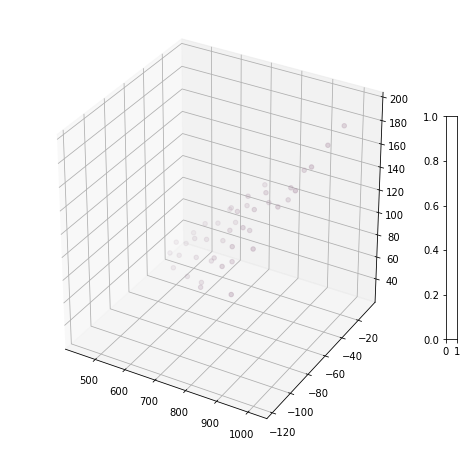

In [83]:
# plot from unprocessed file
cluster_idx = 200
cluster_data = "cluster_cell_E"

energies = ak.flatten(events["cluster_cell_E"], axis=1)[cluster_idx]
cluster_em_frac = (ak.flatten(ak.flatten(events_arr["cluster_cell_hitsE_EM"])) / (ak.flatten(ak.flatten(events_arr["cluster_cell_hitsE_EM"])) + ak.flatten(ak.flatten(events_arr["cluster_cell_hitsE_nonEM"]))))[cluster_idx]

print(energies)
cell_ids = ak.flatten(events["cluster_cell_ID"], axis=1)[cluster_idx]
plot_cells(cell_ids, cell_dict, cluster_em_frac, "Cluster " + str(cluster_idx) + " energy", "z", "x", "y", plt.cm.magma, "log10(Energy) GeV")

[8.0632963e+00 5.7382135e+00 1.9603779e+00 5.7120144e-01 5.1726711e-01
 1.2369651e+00 3.4777889e+00 3.2833304e+00 5.2776963e-01 1.4399265e+00
 5.3368847e+01 1.0401207e+00 3.5941464e-01 2.0374427e+00 8.4831369e-01
 3.5941464e-01 1.9032740e+01 1.2620063e+00 9.1770478e-02 4.2994466e-02
 1.0550145e+01 1.9207911e-01 5.9952044e-01 4.8771911e+00 2.3515496e+00
 1.1638335e+00 7.1982242e-02 8.5863225e-02 4.9668178e-01 3.1750965e-01
 4.6521747e-01 5.5646944e-01 1.9018006e+00 6.0433112e-03 9.4240046e-01
 3.2450956e-01 4.5955446e-02 1.7036532e-01 3.7096411e-02 1.2969257e-02
 7.5190156e-03 1.1651007e-02 1.2482007e-02]


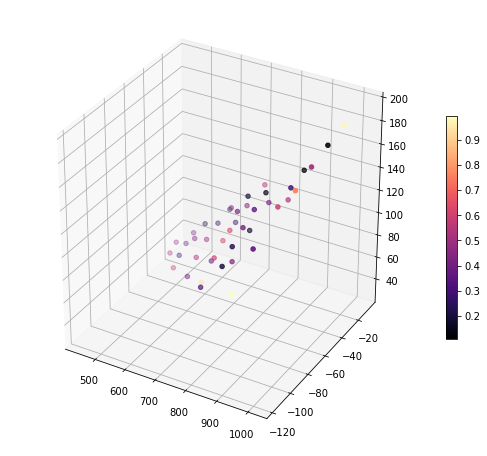

In [81]:
# plot from processed file
print(processed_event_data["cluster_cell_E"][cluster_idx])
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
p = ax.scatter(processed_event_data["z"][cluster_idx], processed_event_data["x"][cluster_idx], processed_event_data["y"][cluster_idx], c=processed_event_data["truth_EM_frac"][cluster_idx], cmap=plt.cm.magma)
fig.colorbar(p, fraction=0.025)

In [80]:
print(fully_processed_data["Y"][cluster_idx][:5])

[[0.40507299]
 [0.20180456]
 [0.10738327]
 [0.28190911]
 [0.27070731]]


In [5]:
# update max number of points files
pion_dir = "/data/mjovanovic/train_testing_data/pion_pointnet_cartesian"
pipm1_file_nums = [1,3,5,7,9]
pipm2_file_nums = [2,4,6,8,10]
pi0_file_nums = [1,2,3,5,6]
len_file = 6000
i_low = 0
i_high = 0

def pion_file_generator(pion_files):
    for file in pion_files:
        X = np.load(pion_dir + file, allow_pickle=True)["X"]
        yield X.shape[1]

with open(pion_dir + '/max_points.txt') as f:
    N = int(f.readline())

with open(pion_dir + '/max_points.txt') as f:
    N = max(N, int(f.readline()))

pion_files = []
for j, pi0_num in enumerate(pi0_file_nums):
    pion_files.extend(list(map(lambda i:  "/pi0_" + str(pi0_num) + "_pipm_" + str(pipm1_file_nums[j]) + "_" + str(pipm2_file_nums[j]) + "_len_" + str(len_file) + "_i_" + str(i) + "_cartesian.npz", np.arange(i_low, i_high + 1))))

for len in pion_file_generator(pion_files):
    if len > N:
        N = len
        print("found larger num points:", N)

assert(False)
with open(pion_dir + 'val/max_points.txt', 'w') as f:
    f.write('%d' % N)

with open(pion_dir + 'train/max_points.txt', 'w') as f:
    f.write('%d' % N)

print(N)

# takes 4 min to run on a full set of 200 files

686
601
595
636
589
558
731
712
680
582
580
669
693
597
660
819
572
670
649
633
708
694
555
796
586
718
580
569
663
672
586
593
647
583
726
652
673
767
607
642
652
631
567
661
626
651
800
785
618
696
624
576
629
572
679
645
633
614
632
601
602
724
657
613
663
678
528
617
703
669
604
585
619
541
643
563
611
675
587
611
708
551
666
592
589
783
645
692
518
586
623
605
624
679
655
592
705
611
656
572
647
718
708
648
755
644
623
642
625
734
664
642
601
564
658
646
764
705
657
629
663
681
668
674
617
582
697
713
710
673
740
591
659
675
578
566
638
614
641
781
626
644
700
634
678
668
614
643
647
724
616
713
631
626
598
726
618
596
636
679
768
703
577
695
672
590
639
707
599
649
902
698
584
737
655
756
675
582
612
669
588
638
671
569
688
598
758
634
632
676
616
619
592
640
603
647
687
654
661
649


AssertionError: 